## import 

In [21]:
!python -m pip install polars

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
import scipy.stats as stats
import polars as pl

In [2]:
# calc lowerbound based on sampled sentences
grammar_names = [
    "Base",
    "DeterministicShuffle",
    "NonDeterministicShuffle",
    "LocalShuffle",
    "EvenOddShuffle",
    "NoReverse",
    "PartialReverse",
    "FullReverse",
]
results_dir = Path("../results").resolve()
dataset_dir = Path("../data/fairseq_train/eos_zipf_min1_max_10").resolve()
total_count = 100_000_000
split_num = 10
lower_bound_complexity = []
for grammar_name in grammar_names:
    counts_file = (
        results_dir
        / "length_sampling"
        / f"100M_samples_eos_zipf_min1_max20{'_' + grammar_name if grammar_name != 'Base' else ''}.sample_counts.csv.gz"
    )
    # polarsで読んで、count / total_countで確率を計算
    counts_df = pl.read_csv(counts_file, new_columns=["sentence", "count"])
    counts_df = counts_df.with_column(pl.col("count") / total_count).alias(
        "probability"
    )

    sentences_in_data = []
    for split_i in range(split_num):
        split_file = dataset_dir / grammar_name / f"split_{split_i}.test"
        with open(split_file, "r") as f:
            sentences_in_data.extend(
                [line.strip() + " [eos]" for line in f.readlines()]
            )

    # dataに含まれるsentenceの確率を取得
    sentences_in_data = pl.DataFrame(sentences_in_data, columns=["sentence"])
    sentences_in_data = sentences_in_data.join(counts_df, on="sentence", how="left")
    assert sentences_in_data["probability"].null_count() == 0

    # lower boundを計算
    entropy = stats.entropy(sentences_in_data["probability"].to_numpy(), base=2)
    perplexity = 2**entropy
    lower_bound_complexity.append(
        {
            "grammar_name": grammar_name,
            "lower_bound_entropy": entropy,
            "lower_bound_perplexity": perplexity,
        }
    )

FileNotFoundError: No such file or directory (os error 2): ...nt_entropy/results/length_sampling/100M_samples_eos_zipf_min1_max20.sample_counts.csv.gz

In [27]:
# calc lowerbound based on sampled sentences
grammar_names = [
    "Base",
    "DeterministicShuffle",
    "NonDeterministicShuffle",
    "LocalShuffle",
    "EvenOddShuffle",
    "NoReverse",
    "PartialReverse",
    "FullReverse",
]
results_dir = Path("../results").resolve()
dataset_dir = Path("../data/fairseq_train/eos_zipf_min1_max_10").resolve()
total_count = 100_000_000
split_num = 10
lower_bound_complexity = []
for grammar_name in grammar_names:
    counts_file = (
        results_dir
        / "length_sampling"
        / f"100M_samples_eos_zipf_min1_max20{'_' + grammar_name if grammar_name != 'Base' else ''}"
        / "sample_counts.csv.gz"
    )
    # pandasで読んで、count / total_countで確率を計算
    counts_df = pd.read_csv(counts_file, names=["sentence", "count"], encoding="utf-8")
    counts_df["probability"] = counts_df["count"] / total_count

    sentences_in_data = []
    for split_i in range(split_num):
        split_file = dataset_dir / grammar_name / f"split_{split_i}.test"
        with open(split_file, "r") as f:
            sentences_in_data.extend(
                [line.strip() + " [eos]" for line in f.readlines()]
            )

    # dataに含まれるsentenceの確率を取得
    sentences_in_data_df = pd.DataFrame(sentences_in_data, columns=["sentence"])
    sentences_in_data_df = sentences_in_data_df.merge(
        counts_df, on="sentence", how="left"
    )
    assert sentences_in_data_df["probability"].isnull().sum() == 0

    # lower boundを計算
    entropy = stats.entropy(sentences_in_data_df["probability"].to_numpy(), base=2)
    perplexity = 2**entropy
    lower_bound_complexity.append(
        {
            "grammar_name": grammar_name,
            "lower_bound_entropy": entropy,
            "lower_bound_perplexity": perplexity,
        }
    )

error: Error -3 while decompressing data: invalid distance too far back

In [2]:
grammar_names = [
    "Base",
    "DeterministicShuffle",
    "NonDeterministicShuffle",
    "LocalShuffle",
    "EvenOddShuffle",
    "NoReverse",
    "PartialReverse",
    "FullReverse",
]
num_splits = 10
model_names = ["lstm", "transformer"]
results_dir = Path("../results").resolve()

result_list = []
for grammar_name in grammar_names:
    for model_name in model_names:
        model_result_dir = results_dir / f"{model_name}_results"
        grammar_result_dir = model_result_dir / grammar_name
        grammar_scores = []
        for split_i in range(num_splits):
            split_result_file = grammar_result_dir / f"split_{split_i}.test.scores.txt"
            with open(split_result_file) as f:
                scores = [float(line.strip()) for line in f]
            grammar_scores.extend(scores)
        grammar_probs = [np.exp(score) for score in grammar_scores]
        entropy = stats.entropy(grammar_probs, base=2)
        perplexity = 2**entropy
        result_list.append(
            {
                "model_name": model_name,
                "grammar_name": grammar_name,
                "entropy": entropy,
                "perplexity": perplexity,
            }
        )

In [3]:
result_df = pd.DataFrame(result_list).sort_values(["model_name", "grammar_name"])
result_df

,model_name,grammar_name,entropy,perplexity
0,lstm,Base,7.314531,159.181694
2,lstm,DeterministicShuffle,6.705513,104.366384
8,lstm,EvenOddShuffle,7.431542,172.630320
14,lstm,FullReverse,7.336065,161.575555
6,lstm,LocalShuffle,7.598155,193.763704
10,lstm,NoReverse,7.490242,179.799136
4,lstm,NonDeterministicShuffle,6.925852,121.587571
12,lstm,PartialReverse,7.250781,152.300988
1,transformer,Base,7.392836,168.060367
3,transformer,DeterministicShuffle,4.059905,16.678353


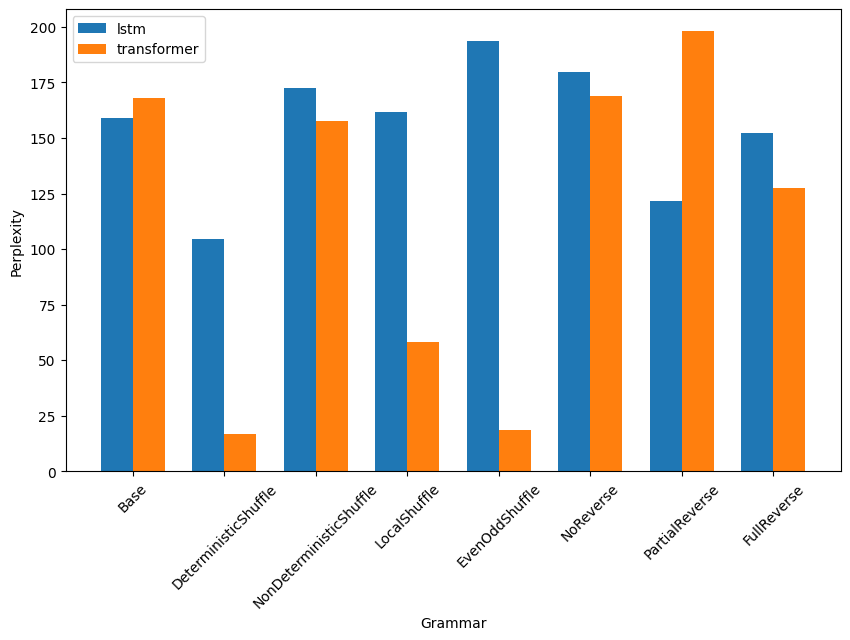

In [6]:
# plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35

for i, model_name in enumerate(model_names):
    model_results = result_df[result_df["model_name"] == model_name]
    ax.bar(
        np.arange(len(grammar_names)) + i * bar_width,
        model_results["perplexity"],
        bar_width,
        label=model_name,
    )

ax.set_xticks(np.arange(len(grammar_names)) + bar_width / 2)
ax.set_xticklabels(grammar_names, rotation=45)
ax.set_xlabel("Grammar")
ax.set_ylabel("Perplexity")
ax.legend()
plt.show()